In [64]:
# Import Libraries

import pandas as pd
import numpy as np


In [65]:
# Load cleaned data

data = pd.read_csv(r'C:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\Data Cleaning&EDA\cleaned_data.csv')

data.head(2)

,Product_ID,Category,Price,Date,Season,Market_Trend_Index,Competitor_Activity_Score,Consumer_Confidence_Index,Product_Specification_1,Product_Specification_2,Sales_Volume
0,1103,Laptop,105.32,2009-01-01,Winter,-1.859160,0.546694,84.680465,Spec_C,Long-Battery-Life,49
1,1436,Tablet,145.55,2009-01-01,Winter,-0.345587,0.940428,42.919288,Spec_C,Lightweight,69


In [29]:
# Convert 'Date' column to datetime format and set as index for time series analysis
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


data.head(2)


,Product_ID,Category,Price,Season,Market_Trend_Index,Competitor_Activity_Score,Consumer_Confidence_Index,Product_Specification_1,Product_Specification_2,Sales_Volume
Date,,,,,,,,,,
2009-01-01,1103,Laptop,105.32,Winter,-1.859160,0.546694,84.680465,Spec_C,Long-Battery-Life,49
2009-01-01,1436,Tablet,145.55,Winter,-0.345587,0.940428,42.919288,Spec_C,Lightweight,69


**Features check for Data Leakage**

Features unlikely to cause leakage (Safe to use as features):

a. Product_ID – OK -- identifier.

b. Category – OK -- static product info.

c. Price – OK -- known at time of sale and a key driver.

d. Date – OK -- can derive temporal patterns like seasonality.

e. Season – OK --derived from date; not a leakage risk.

f. Market_Trend_Index – OK -- assumed to be external and known at prediction time.

g. Consumer_Confidence_Index – OK -- also assumed to be known at prediction time.

h. Product_Specification_1 - OK -- product metadata and static.

i. Product_Specification_2 – OK -- product metadata and static

**Potential Leakage Column:**

i. Competitor_Activity_Score - LEAKY (If the score is computed on actual market outcomes or competitor performance after the fact, and not from publicly known information before the sale)

ii. Competitor_Activity_Score - OK (If it is based on historical or real-time publicly available data at the time of the sale).

**Recommendation:**

a. Lag Competitor_Activity_Score and encode categorical variables


In [14]:
data.shape

(136193, 10)

**ACF Plot**

<Figure size 1200x500 with 0 Axes>

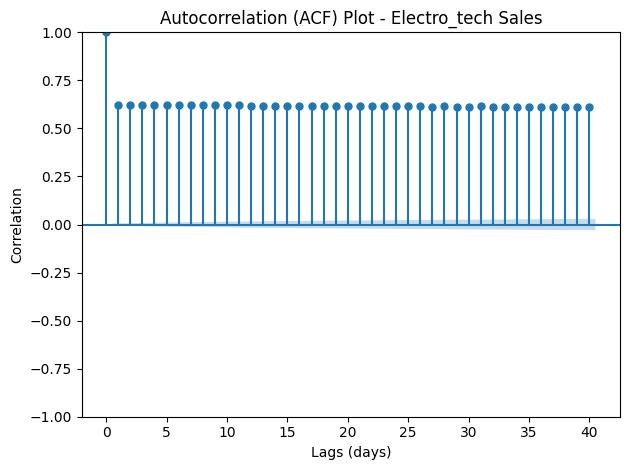

In [4]:
# ACF Plot to Check for Seasonality
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plot_acf(data["Sales_Volume"], lags=40)
plt.title("Autocorrelation (ACF) Plot - Electro_tech Sales")
plt.xlabel("Lags (days)")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

**Test for Stationarity**

In [48]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

numeric_data = data.select_dtypes(include='number')

adf_results = {}

for col in numeric_data.columns:
    series = numeric_data[col].dropna()
    
    result = adfuller(series)
    
    adf_results[col] = {
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Lags Used": result[2],
        "Observations": result[3],
        "Critical Values": result[4]
    }

for col, res in adf_results.items():
    print(f"\nADF Test for {col}")
    print(f"ADF Statistic: {res['ADF Statistic']:.4f}")
    print(f"p-value: {res['p-value']:.6f}")
    print(f"Critical Values: {res['Critical Values']}")



ADF Test for Product_ID
ADF Statistic: -370.0695
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.4303980162069485), '5%': np.float64(-2.8615612224733513), '10%': np.float64(-2.566781295969112)}

ADF Test for Price
ADF Statistic: -35.0742
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.4303980419583073), '5%': np.float64(-2.8615612338549896), '10%': np.float64(-2.56678130202717)}

ADF Test for Market_Trend_Index
ADF Statistic: -368.5634
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.4303980162069485), '5%': np.float64(-2.8615612224733513), '10%': np.float64(-2.566781295969112)}

ADF Test for Competitor_Activity_Score
ADF Statistic: -369.8756
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.4303980162069485), '5%': np.float64(-2.8615612224733513), '10%': np.float64(-2.566781295969112)}

ADF Test for Consumer_Confidence_Index
ADF Statistic: -150.3445
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.430398017969859), '5%': np.float64(-2.8615612232525

In [49]:
import pandas as pd

rows = []

for col in numeric_data.columns:
    result = adfuller(numeric_data[col].dropna())
    rows.append({
        "Column": col,
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Stationary (p<0.05)": result[1] < 0.05
    })

adf_df = pd.DataFrame(rows)
print(adf_df)


                      Column  ADF Statistic       p-value  Stationary (p<0.05)
0                 Product_ID    -370.069450  0.000000e+00                 True
1                      Price     -35.074203  0.000000e+00                 True
2         Market_Trend_Index    -368.563412  0.000000e+00                 True
3  Competitor_Activity_Score    -369.875644  0.000000e+00                 True
4  Consumer_Confidence_Index    -150.344543  0.000000e+00                 True
5               Sales_Volume      -6.150297  7.590997e-08                 True


The result shows the dataset is stationary.

**Mutual Info Regression**

                     Feature  MI_Score
2                      Price  4.927765
0                 Product_ID  2.887902
3                     Season  0.345399
4         Market_Trend_Index  0.010257
7    Product_Specification_1  0.001436
1                   Category  0.000000
5  Competitor_Activity_Score  0.000000
6  Consumer_Confidence_Index  0.000000
8    Product_Specification_2  0.000000


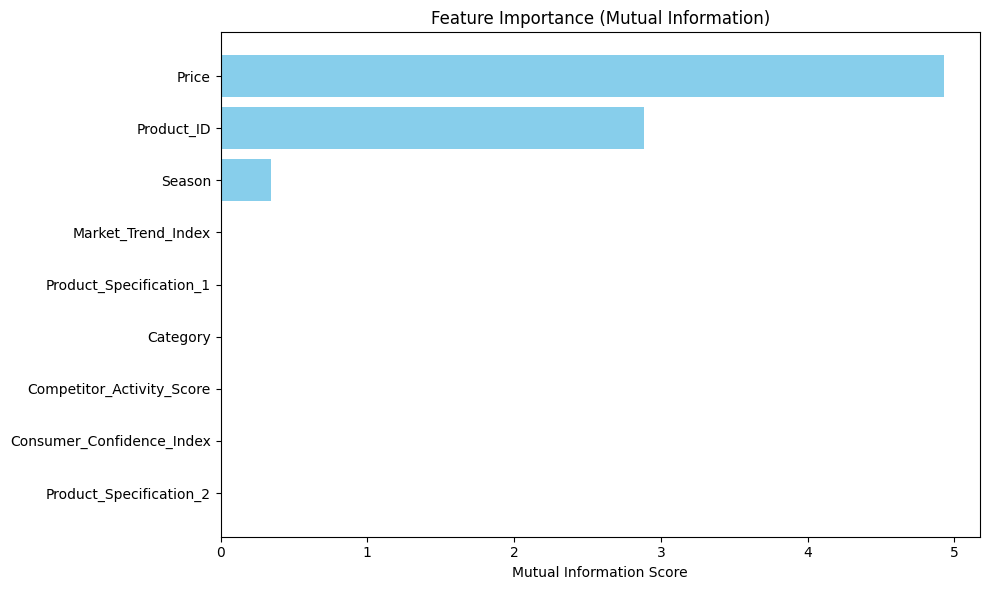

In [50]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# Copy original data
mi_data = data

# Define the feature and target matrix
X = mi_data.drop(columns=['Sales_Volume'])
target = mi_data['Sales_Volume']

# Convert string/object columns to category type
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Compute mutual information scores
mi_scores = mutual_info_regression(X, target, discrete_features=True, random_state=42)

# Create DataFrame of feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

# Display the result
print(feature_importance)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['MI_Score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance (Mutual Information)')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()

**Feature Engineering**

In [66]:
# --- Feature Engineering for Low-MI Features ---

# Copy original data
data = data.copy()

# Lag Feature for Competitor Score 
data = data.sort_values(['Product_ID', 'Date'])
data['Competitor_Score_Lag1'] = data.groupby('Product_ID')['Competitor_Activity_Score'].shift(1)

# Handle any NaN values introduced by lag features
data.dropna(inplace=True)

# Drop original Competitor_Activity_Score column
data = data.drop(columns=['Competitor_Activity_Score'])


data.head(2)

,Product_ID,Category,Price,Date,Season,Market_Trend_Index,Consumer_Confidence_Index,Product_Specification_1,Product_Specification_2,Sales_Volume,Competitor_Score_Lag1
719,1001,Accessories,164.15,2009-01-26,Winter,-0.873212,79.837034,Spec_B,High-Resolution,46,2.329033
932,1001,Smartphone,165.86,2009-02-02,Winter,-0.214781,83.112046,Spec_A,Long-Battery-Life,44,0.108857


**Check to determine the suitable encoding method**

In [24]:
data['Category'].unique()

array(['Smartphone', 'Tablet', 'Laptop', 'Accessories'], dtype=object)

In [25]:
data['Season'].unique()

array(['Spring', 'Summer', 'Fall', 'Winter'], dtype=object)

In [26]:
data['Product_Specification_1'].unique()	

array(['Spec_B', 'Spec_C', 'Spec_A'], dtype=object)

In [27]:
data['Product_Specification_2'].unique()

array(['Lightweight', 'High-Resolution', 'Long-Battery-Life'],
      dtype=object)

In [49]:
data['Product_ID'].nunique()

694

**Encoding**

In [67]:
# Encoding Categorical Variables

data_encoded = data.copy()

# One-Hot Encoding 
categorical_cols = ['Category', 'Product_Specification_1', 'Product_Specification_2']

# One-hot encode 
data_encoded = pd.get_dummies(data, columns=categorical_cols)

# Convert all boolean columns to int 
bool_cols = data_encoded.select_dtypes(include='bool').columns
data_encoded[bool_cols] = data_encoded[bool_cols].astype(int)

# Ordinal Encoding for Season
season_order = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
data_encoded['Season_Encoded'] = data_encoded['Season'].map(season_order)

# Drop original 'Season' column after encoding
data_encoded.drop(columns=['Season'], inplace=True)

# Frequency Encoding for Product_ID
freq_map = data_encoded['Product_ID'].value_counts().to_dict()
data_encoded['Product_ID_Frequency'] = data_encoded['Product_ID'].map(freq_map)

# Drop original if needed
data_encoded.drop(columns=['Product_ID'], inplace=True)

# Update data to encoded version
data = data_encoded.copy()

# Show result
data.head(2)


,Price,Date,Market_Trend_Index,Consumer_Confidence_Index,Sales_Volume,Competitor_Score_Lag1,Category_Accessories,Category_Laptop,Category_Smartphone,Category_Tablet,Product_Specification_1_Spec_A,Product_Specification_1_Spec_B,Product_Specification_1_Spec_C,Product_Specification_2_High-Resolution,Product_Specification_2_Lightweight,Product_Specification_2_Long-Battery-Life,Season_Encoded,Product_ID_Frequency
719,164.15,2009-01-26,-0.873212,79.837034,46,2.329033,1,0,0,0,0,1,0,1,0,0,4,177
932,165.86,2009-02-02,-0.214781,83.112046,44,0.108857,0,0,1,0,1,0,0,0,0,1,4,177


                                      Feature  MI_Score
0                                       Price  4.925879
15                       Product_ID_Frequency  0.757350
14                             Season_Encoded  0.345439
3                       Competitor_Score_Lag1  0.011248
11    Product_Specification_2_High-Resolution  0.003212
1                          Market_Trend_Index  0.003050
6                         Category_Smartphone  0.001706
13  Product_Specification_2_Long-Battery-Life  0.001202
8              Product_Specification_1_Spec_A  0.000973
5                             Category_Laptop  0.000688
10             Product_Specification_1_Spec_C  0.000549
9              Product_Specification_1_Spec_B  0.000468
4                        Category_Accessories  0.000202
7                             Category_Tablet  0.000043
2                   Consumer_Confidence_Index  0.000000
12        Product_Specification_2_Lightweight  0.000000


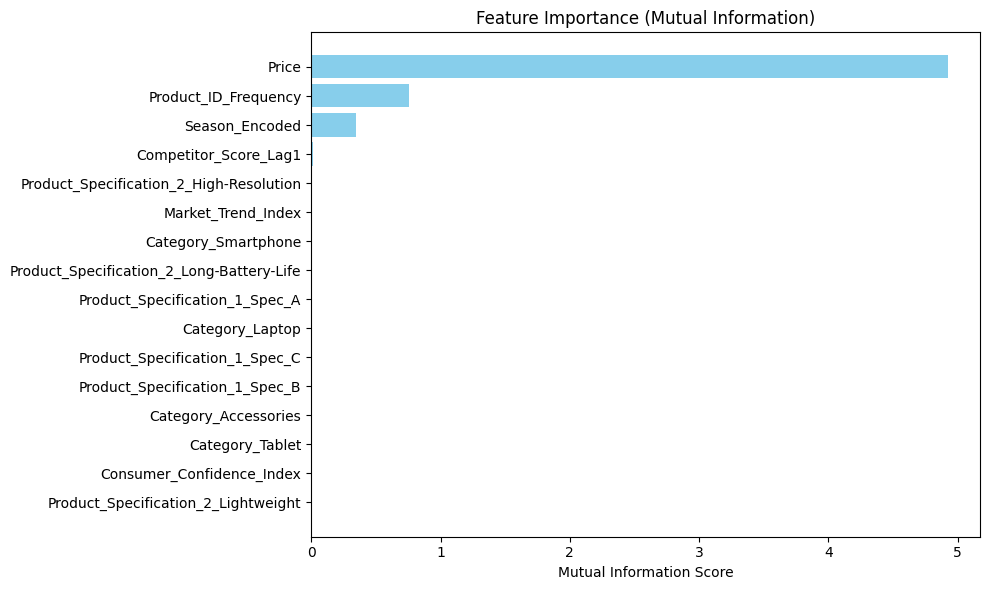

In [53]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# Copy original data
mi_data = data

# Define the feature and target matrix
X = mi_data.drop(columns=['Sales_Volume'])
target = mi_data['Sales_Volume']

# Convert string/object columns to category type
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Compute mutual information scores
mi_scores = mutual_info_regression(X, target, discrete_features=True, random_state=42)

# Create DataFrame of feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

# Display the result
print(feature_importance)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['MI_Score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance (Mutual Information)')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()


**Modeling**

Sales_Volume is the only appropriate target variable (y) as it represents customer actual demand, and aligns with the project objectives of reducing stock discrepancies, improving inventory planning, ensuring product availability, preventing financial loss from under/over-stocking and increasing  customer satisfaction. All other columns serve best as input features (X).

**Split the data**

In [68]:
train_size = int(len(data) * 0.8)



**Split the data with endogenous features**

In [69]:
# Select features and target for training and testing

# Define endogenous (target) variable
target = 'Sales_Volume'

# Split data into train and test using only the endogenous variable
y_train = data[target].iloc[:train_size]
y_test = data[target].iloc[train_size:]


**Train ARIMA using MLFlow**

In [ ]:
import mlflow

# Set experiment
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("Electrotech_Sales_Forecasting") # Experiment name


c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, fre

arima_mae: 45.75719632375425
arima_rmse: 55.302719173236454
arima_r2: -0.004601627016733056


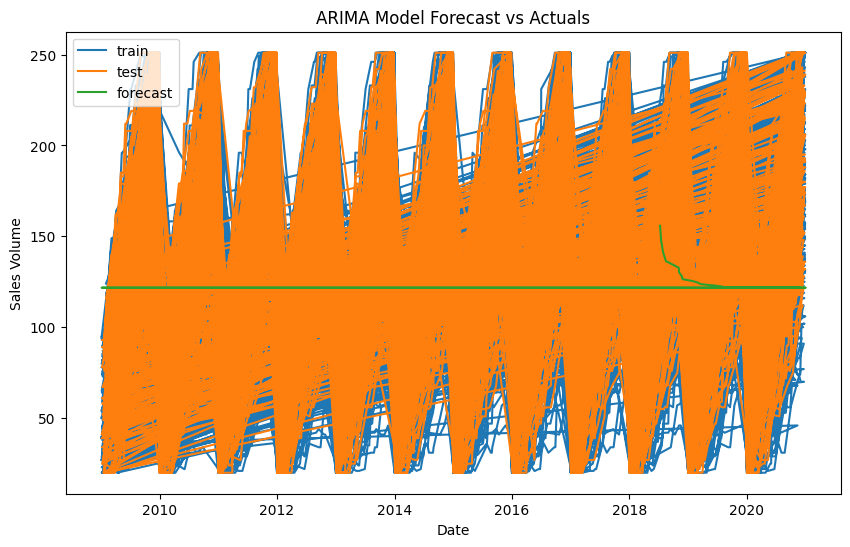

In [35]:
# Libraries for ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np

with mlflow.start_run(run_name="ARIMA model"):
    # ARIMA model — note: no seasonal_order, no exog
    arima_model = ARIMA(
        endog=y_train,
        order=(1, 0, 1)
    ).fit()

    # Forecast the same number of steps as test set
    arima_forecast = arima_model.forecast(steps=len(y_test))

    # Evaluate
    arima_mae = mean_absolute_error(y_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
    arima_r2 = r2_score(y_test, arima_forecast)

    print("arima_mae:", arima_mae)
    print("arima_rmse:", arima_rmse)
    print("arima_r2:", arima_r2)

    # Log params and metrics
    mlflow.log_param("order", (1, 0, 1))
    mlflow.log_param("model_type", "ARIMA")

    mlflow.log_metric("MAE", arima_mae)
    mlflow.log_metric("RMSE", arima_rmse)
    mlflow.log_metric("R2 Score", arima_r2)

    # Save model
    model_filename = "arima_model.joblib"
    with open(model_filename, "wb") as f:
        joblib.dump(arima_model, f)
    mlflow.log_artifact(model_filename)

    # Plot forecast
    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label='train')
    plt.plot(y_test.index, y_test, label='test')
    plt.plot(y_test.index, arima_forecast, label='forecast')
    plt.legend()
    plt.title("ARIMA Model Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Sales Volume")
    plt.savefig("arima_forecast.png")

    mlflow.log_artifact("arima_forecast.png")
    plt.show()


**Auto Arima**

In [36]:
from pmdarima import auto_arima

model = auto_arima(
    y_train,
    seasonal=False,        # Still plain ARIMA (no seasonal component)
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=0,                   # Confirmed stationary
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,         
    information_criterion='aic'
)

print(model.summary())
print("Best ARIMA order (p,d,q):", model.order)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1367773.216, Time=1.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1256374.597, Time=5.76 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1193810.853, Time=10.49 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1158881.657, Time=16.71 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1137634.922, Time=23.99 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=1124124.870, Time=30.65 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1079327.037, Time=1.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1079104.335, Time=2.85 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1078561.175, Time=8.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1071892.320, Time=33.46 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1066803.697, Time=53.70 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1079132.270, Time=3.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1066563.876, Time=40.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1065829.028, Time=43.72 sec
 ARIMA(2,0,3)(0,0,0)[0]   

**Optimised ARIMA Model**

c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, fre

arima_mae: 45.75769672905024
arima_rmse: 55.303549020933154
arima_r2: -0.004631776442061808


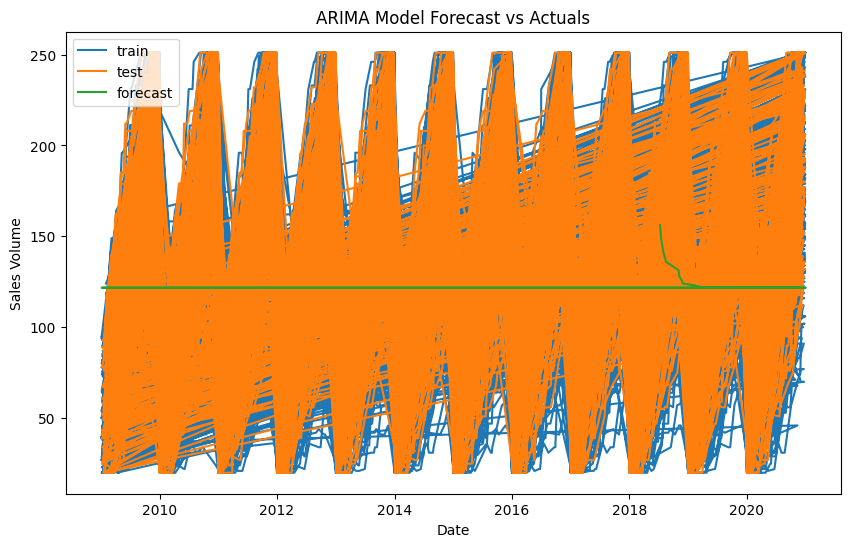

In [37]:
# Libraries for ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np

with mlflow.start_run(run_name="ARIMA model"):
    # ARIMA model — note: no seasonal_order, no exog
    arima_model = ARIMA(
        endog=y_train,
        order=(4, 0, 1)
    ).fit()

    # Forecast the same number of steps as test set
    arima_forecast = arima_model.forecast(steps=len(y_test))

    # Evaluate
    arima_mae = mean_absolute_error(y_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
    arima_r2 = r2_score(y_test, arima_forecast)

    print("arima_mae:", arima_mae)
    print("arima_rmse:", arima_rmse)
    print("arima_r2:", arima_r2)

    # Log params and metrics
    mlflow.log_param("order", (4, 0, 1))
    mlflow.log_param("model_type", "ARIMA")

    mlflow.log_metric("MAE", arima_mae)
    mlflow.log_metric("RMSE", arima_rmse)
    mlflow.log_metric("R2 Score", arima_r2)

    # Save model
    model_filename = "arima_model.joblib"
    with open(model_filename, "wb") as f:
        joblib.dump(arima_model, f)
    mlflow.log_artifact(model_filename)

    # Plot forecast
    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label='train')
    plt.plot(y_test.index, y_test, label='test')
    plt.plot(y_test.index, arima_forecast, label='forecast')
    plt.legend()
    plt.title("ARIMA Model Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Sales Volume")
    plt.savefig("arima_forecast.png")

    mlflow.log_artifact("arima_forecast.png")
    plt.show()


**SARIMAX Model**

**Prophet Model**

Importing plotly failed. Interactive plots will not work.
22:14:11 - cmdstanpy - INFO - Chain [1] start processing
22:14:51 - cmdstanpy - INFO - Chain [1] done processing


prophet_mae: 57.60424755173232
prophet_rmse: 70.82546689055854
prophet_r2: -0.6477062848335156


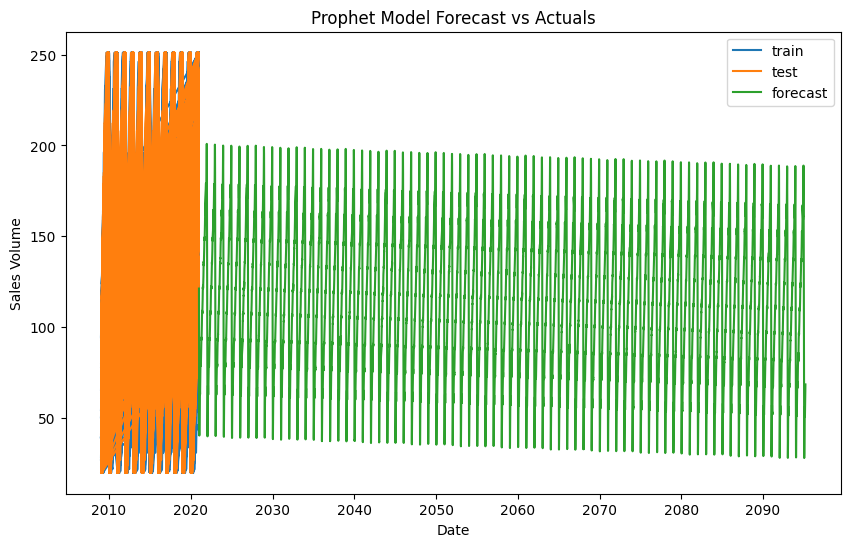

In [36]:
# Libraries for Prophet
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Prepare training DataFrame for Prophet
train_df = y_train.reset_index().rename(columns={
    y_train.index.name: 'ds',   # use index name dynamically
    'Sales_Volume': 'y'
})

# Prepare testing DataFrame for Prophet
test_df = y_test.reset_index().rename(columns={
    y_test.index.name: 'ds',
    'Sales_Volume': 'y'
})


with mlflow.start_run(run_name="Prophet model"):
    # Fit Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_df)

    # Create future dataframe
    future = prophet_model.make_future_dataframe(periods=len(y_test), freq='D')
    forecast = prophet_model.predict(future)

    # Extract only forecast values for test period
    forecast_test = forecast[['ds', 'yhat']].iloc[-len(y_test):].set_index('ds')
    y_test_actual = y_test.copy()
    y_test_actual.index = pd.to_datetime(y_test_actual.index)

    # Evaluation
    prophet_mae = mean_absolute_error(y_test_actual, forecast_test['yhat'])
    prophet_rmse = np.sqrt(mean_squared_error(y_test_actual, forecast_test['yhat']))
    prophet_r2 = r2_score(y_test_actual, forecast_test['yhat'])

    print("prophet_mae:", prophet_mae)
    print("prophet_rmse:", prophet_rmse)
    print("prophet_r2:", prophet_r2)

    # Log parameters and metrics
    mlflow.log_param("model_type", "Prophet")
    mlflow.log_metric("MAE", prophet_mae)
    mlflow.log_metric("RMSE", prophet_rmse)
    mlflow.log_metric("R2 Score", prophet_r2)

    # Save model
    model_filename = "prophet_model.joblib"
    with open(model_filename, "wb") as f:
        joblib.dump(prophet_model, f)
    mlflow.log_artifact(model_filename)

    # Plot forecast
    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label='train')
    plt.plot(y_test.index, y_test, label='test')
    plt.plot(forecast_test.index, forecast_test['yhat'], label='forecast')
    plt.legend()
    plt.title("Prophet Model Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Sales Volume")
    plt.savefig("prophet_forecast.png")

    mlflow.log_artifact("prophet_forecast.png")
    plt.show()


In [38]:
# Select features and target for training and testing

# Define target and exogenous features for Prophet
target = 'Sales_Volume'
exog_features = ['Price', 'Product_ID_Frequency', 'Season_Encoded']

# Determine split point
train_size = int(len(data) * 0.8)

# Split data into train and test
y_train = data[target].iloc[:train_size]
y_test = data[target].iloc[train_size:]

X_train = data[exog_features].iloc[:train_size]
X_test = data[exog_features].iloc[train_size:]

# Combine y and exog into Prophet training DataFrame
train_df = pd.concat([y_train, X_train], axis=1).reset_index()
train_df.rename(columns={'Date': 'ds', target: 'y'}, inplace=True)

# Combine y and exog into Prophet testing DataFrame
test_df = pd.concat([y_test, X_test], axis=1).reset_index()
test_df.rename(columns={'Date': 'ds', target: 'y'}, inplace=True)


13:48:26 - cmdstanpy - INFO - Chain [1] start processing
13:49:04 - cmdstanpy - INFO - Chain [1] done processing


prophet_mae: 56.98655558474372
prophet_rmse: 69.3641684565998
prophet_r2: -0.5804154787284745


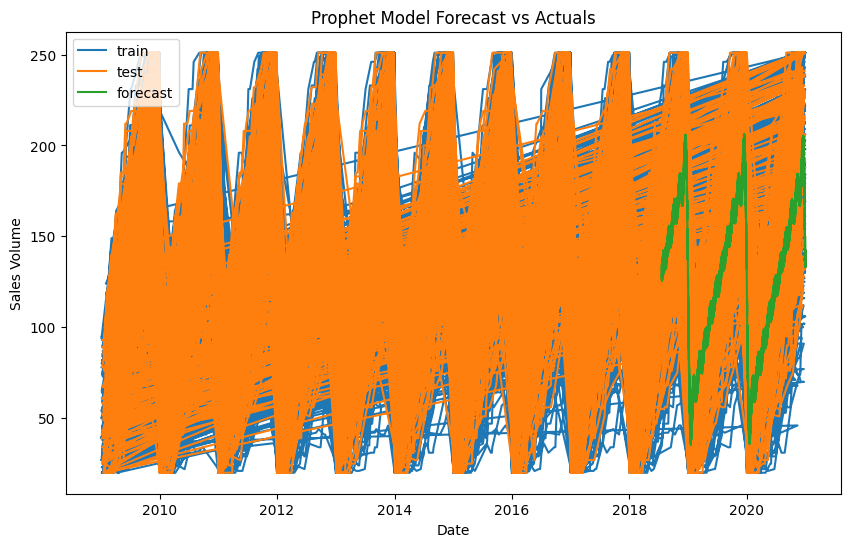

In [39]:
# Cell 2: Prophet Forecast with Exogenous Regressors

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import joblib
import matplotlib.pyplot as plt
import numpy as np

with mlflow.start_run(run_name="Prophet with Exogenous"):
    # Initialize Prophet model
    prophet_model = Prophet()

    # Add all exogenous regressors
    for feature in exog_features:
        prophet_model.add_regressor(feature)

    # Fit the model
    prophet_model.fit(train_df)

    # Combine train and test for future prediction with exog values
    future_df = pd.concat([
        train_df[['ds'] + exog_features],
        test_df[['ds'] + exog_features]
    ], ignore_index=True)

    # Forecast
    forecast = prophet_model.predict(future_df)

    # Extract only forecast values for test period
    forecast_test = forecast[['ds', 'yhat']].iloc[-len(test_df):].set_index('ds')
    y_test_actual = y_test.copy()
    y_test_actual.index = pd.to_datetime(y_test_actual.index)

    # Evaluation
    prophet_mae = mean_absolute_error(y_test_actual, forecast_test['yhat'])
    prophet_rmse = np.sqrt(mean_squared_error(y_test_actual, forecast_test['yhat']))
    prophet_r2 = r2_score(y_test_actual, forecast_test['yhat'])

    print("prophet_mae:", prophet_mae)
    print("prophet_rmse:", prophet_rmse)
    print("prophet_r2:", prophet_r2)

    # Log model to MLflow
    mlflow.log_param("model_type", "Prophet")
    mlflow.log_param("exogenous_features", exog_features)
    mlflow.log_metric("MAE", prophet_mae)
    mlflow.log_metric("RMSE", prophet_rmse)
    mlflow.log_metric("R2 Score", prophet_r2)

    # Save the model
    model_filename = "prophet_model.joblib"
    with open(model_filename, "wb") as f:
        joblib.dump(prophet_model, f)
    mlflow.log_artifact(model_filename)

    # Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label='train')
    plt.plot(y_test.index, y_test, label='test')
    plt.plot(forecast_test.index, forecast_test['yhat'], label='forecast')
    plt.legend()
    plt.title("Prophet Model Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Sales Volume")
    plt.savefig("prophet_forecast.png")

    mlflow.log_artifact("prophet_forecast.png")
    plt.show()


**Random Forest Model**

2025/12/16 13:54:14 INFO mlflow.tracking.fluent: Experiment with name 'Sales_Forecasting' does not exist. Creating a new experiment.


MAE: 39.21, RMSE: 50.00, R²: 0.1789


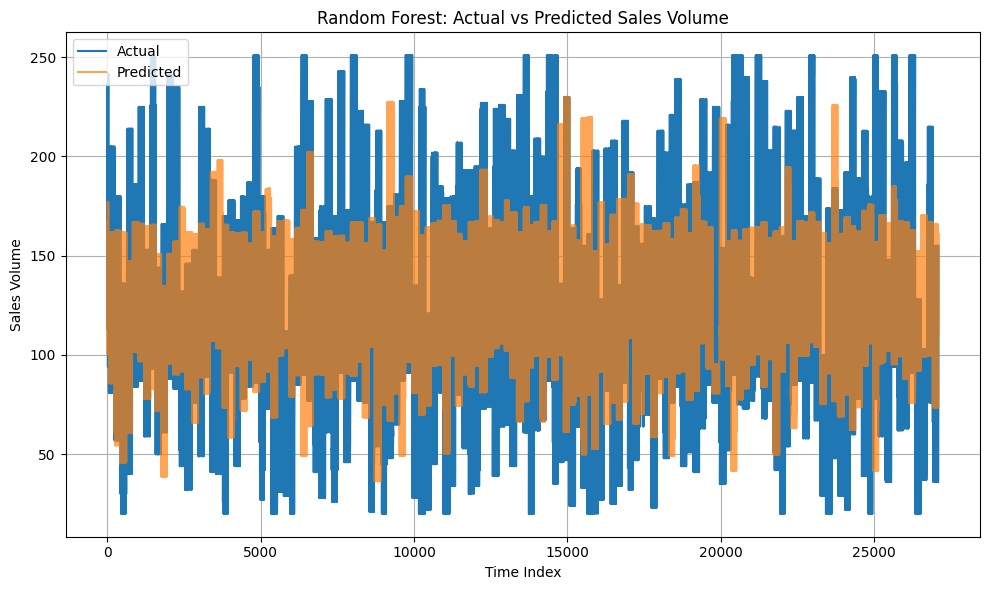

In [40]:
# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
import json
import mlflow
import matplotlib.pyplot as plt

# Define target column
target = 'Sales_Volume'
exclude = ['Consumer_Confidence_Index', target]

# Random Forest features 
rf_features = [col for col in data.columns if col not in exclude]

# Train-Test Split
X = data[rf_features]
y = data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # preserve time order

# MLflow tracking setup
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("Sales_Forecasting")

with mlflow.start_run(run_name="RandomForest_Model"):
    # Model Training
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Prediction
    y_pred = model.predict(X_test)

    # Evaluation
    rf_mae = mean_absolute_error(y_test, y_pred)
    rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rf_r2 = r2_score(y_test, y_pred)

    print(f"MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R²: {rf_r2:.4f}")

    # Log parameters
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("features_used", rf_features)

    # Log metrics
    mlflow.log_metric("MAE", rf_mae)
    mlflow.log_metric("RMSE", rf_rmse)
    mlflow.log_metric("R2", rf_r2)

    # Save model
    model_path = "random_forest_model.joblib"
    joblib.dump(model, model_path)
    mlflow.log_artifact(model_path)

    # Save feature schema
    schema_path = "rf_feature_schema.json"
    with open(schema_path, "w") as f:
        json.dump(rf_features, f)
    mlflow.log_artifact(schema_path)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title("Random Forest: Actual vs Predicted Sales Volume")
    plt.xlabel("Time Index")
    plt.ylabel("Sales Volume")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("rf_forecast.png")
    mlflow.log_artifact("rf_forecast.png")
    plt.show()


**RandomisedSearchCV**

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-p

MAE: 38.16, RMSE: 48.43, R²: 0.2459


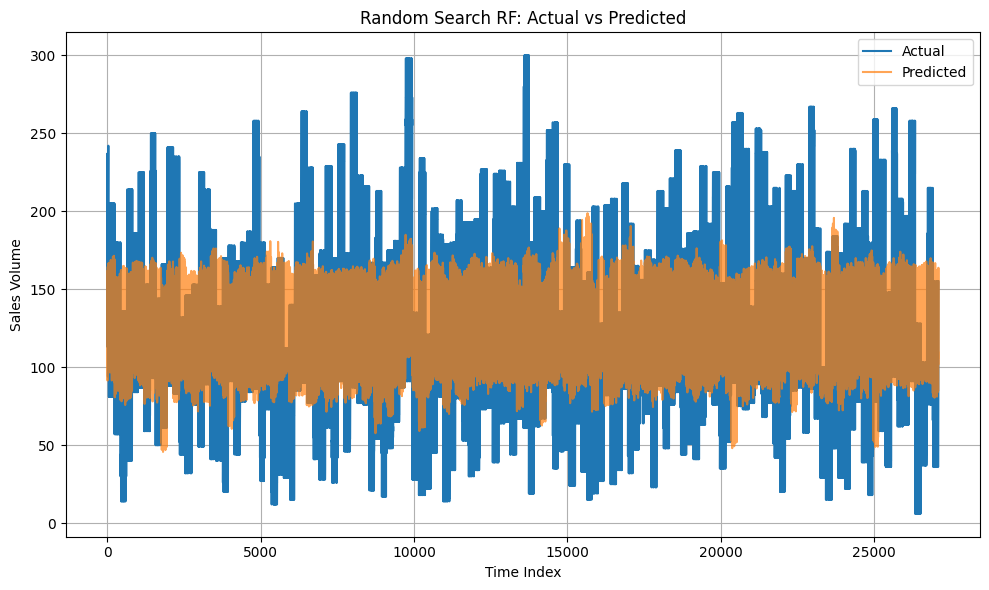

In [11]:
from sklearn.model_selection import RandomizedSearchCV

# Define target column
target = 'Sales_Volume'
exclude = ['Consumer_Confidence_Index', target]

# Random Forest features 
rf_features = [col for col in data.columns if col not in exclude]

# Train-Test Split
X = data[rf_features]
y = data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # preserve time order

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up randomized search
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='r2'
)

mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("Sales_Forecasting")

with mlflow.start_run(run_name="RF_RandomSearch"):
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

    # Log best params
    mlflow.log_params(random_search.best_params_)

    # Log metrics
    mlflow.log_metrics({"MAE": mae, "RMSE": rmse, "R2": r2})

    # Save model
    joblib.dump(best_model, "random_forest_randomsearch.joblib")
    mlflow.log_artifact("random_forest_randomsearch.joblib")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title("Random Search RF: Actual vs Predicted")
    plt.xlabel("Time Index")
    plt.ylabel("Sales Volume")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("rf_randomsearch_forecast.png")
    mlflow.log_artifact("rf_randomsearch_forecast.png")
    plt.show()


In [42]:
data.head(2)

,Price,Market_Trend_Index,Consumer_Confidence_Index,Sales_Volume,Competitor_Score_Lag1,Category_Accessories,Category_Laptop,Category_Smartphone,Category_Tablet,Product_Specification_1_Spec_A,Product_Specification_1_Spec_B,Product_Specification_1_Spec_C,Product_Specification_2_High-Resolution,Product_Specification_2_Lightweight,Product_Specification_2_Long-Battery-Life,Season_Encoded,Product_ID_Frequency
Date,,,,,,,,,,,,,,,,,
2009-01-26,164.15,-0.873212,79.837034,46,2.329033,1,0,0,0,0,1,0,1,0,0,4,177
2009-02-02,165.86,-0.214781,83.112046,44,0.108857,0,0,1,0,1,0,0,0,0,1,4,177


**Scaling with Standardscaler**

c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be g


Category: Accessories
MAE: 45.10, RMSE: 54.32, R²: -0.0150


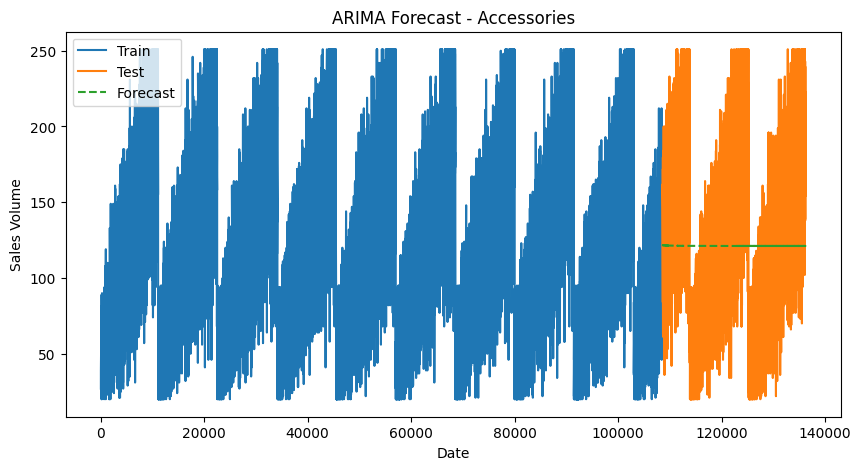

c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be g


Category: Laptop
MAE: 44.83, RMSE: 54.11, R²: -0.0222


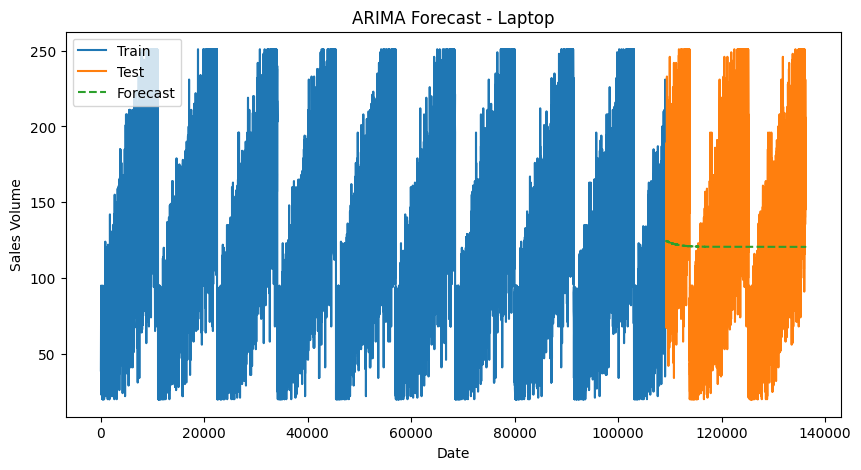

c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be g


Category: Smartphone
MAE: 45.74, RMSE: 55.13, R²: -0.0022


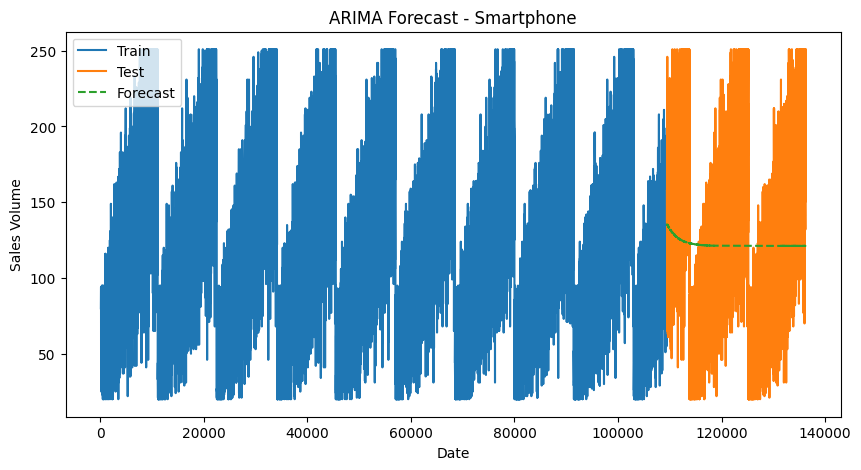

c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Projects\Data Science\Regression\Forecasting Sales for Fast-Moving Consumer Electronic\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be g


Category: Tablet
MAE: 44.71, RMSE: 54.23, R²: -0.0151


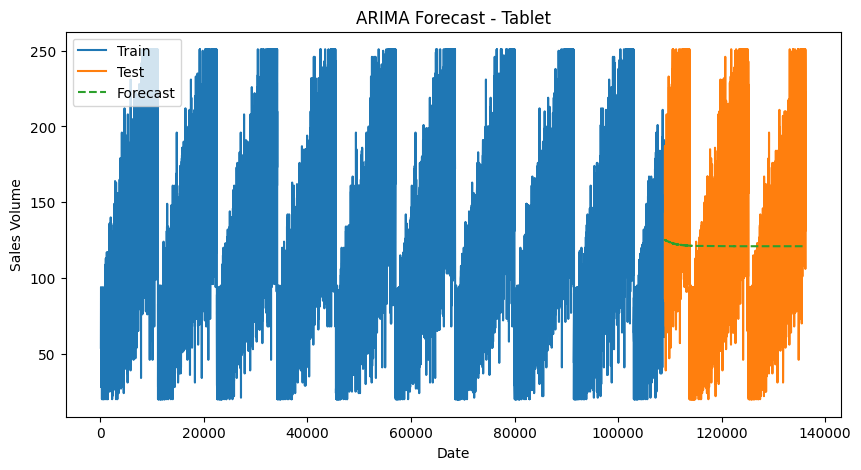

In [81]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np

# Define category columns (one-hot encoded)
category_columns = ['Category_Accessories', 'Category_Laptop', 'Category_Smartphone', 'Category_Tablet']

# Loop through each category
for category_col in category_columns:
    category_name = category_col.replace("Category_", "")  # for naming

    # Filter rows where category = 1
    df_category = data[data[category_col] == 1].copy()

    # Sort by date to preserve time order
    df_category.sort_values("Date", inplace=True)

    # Define target
    y = df_category['Sales_Volume']

    # Split data (e.g. 80% train)
    train_size = int(len(y) * 0.8)
    y_train, y_test = y[:train_size], y[train_size:]

    import mlflow
    # Set experiment
    mlflow.set_tracking_uri("mlruns")
    mlflow.set_experiment("Tech_Sales_Forecasting") # Experiment name

    with mlflow.start_run(run_name=f"ARIMA_{category_name}"):
        # Fit ARIMA model (no seasonal component)
        model = ARIMA(endog=y_train, order=(1, 0, 1)).fit()

        # Forecast
        forecast = model.forecast(steps=len(y_test))

        # Evaluation
        mae = mean_absolute_error(y_test, forecast)
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        r2 = r2_score(y_test, forecast)

        print(f"\nCategory: {category_name}")
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

        # Log to MLflow
        mlflow.log_param("category", category_name)
        mlflow.log_param("order", (1, 0, 1))
        mlflow.log_param("model_type", "ARIMA")

        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)

        # Save model
        model_filename = f"arima_model_{category_name}.joblib"
        joblib.dump(model, model_filename)
        mlflow.log_artifact(model_filename)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(y_train.index, y_train, label="Train")
        plt.plot(y_test.index, y_test, label="Test")
        plt.plot(y_test.index, forecast, label="Forecast", linestyle='--')
        plt.title(f"ARIMA Forecast - {category_name}")
        plt.xlabel("Date")
        plt.ylabel("Sales Volume")
        plt.legend()
        plot_file = f"arima_forecast_{category_name}.png"
        plt.savefig(plot_file)
        mlflow.log_artifact(plot_file)
        plt.show()
